In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import islice

In [223]:
#Importation des données
df = pd.read_csv('../Data/Phishing_Email.csv')
df.drop(['index'], axis=1, inplace=True)
#Récuperation des urls dans les mails
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
df['email_text'] = df['email_text'].astype(str)

df['url'] = ''
df['url']= df["email_text"].str.extract(pattern, expand=True)

print("Nombre de ligne initale:",df.size)
#Suppression des doublons et des valeurs manquantes
df = df.drop_duplicates()
df = df.dropna()
print("Nombre de ligne finale:",df.size)

Nombre de ligne initale: 55950
Nombre de ligne finale: 12084


In [224]:
print(df)

                                              email_text  phishing  \
3      \nHello I am your hot lil horny toy.\n    I am...         1   
6      On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...         0   
11     URL: http://www.newsisfree.com/click/-5,830431...         0   
12     begin forwarded text Date: Wed, 25 Sep 2002 13...         0   
16     The academic discipline of Software Engineerin...         0   
...                                                  ...       ...   
18631  Update of /cvsroot/spamassassin/spamassassin\n...         0   
18633  This article from NYTimes.com \nhas been sent ...         0   
18635  On Fri, 4 Oct 2002, Mark Derricutt wrote:> Any...         0   
18642  URL: http://diveintomark.org/archives/2002/09/...         0   
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...         0   

                                                     url  
3                         http://www.mail.com/?sr=signup  
6              http://www.linux.ie/mailma

In [225]:
#Création de données pour l'analyse de l'url
def extract_url_features(url):
    parsed_url = urlparse(url)
    path_level = parsed_url.path.count('/')
    url_length = len(url)
    num_dash = url.count('-')
    num_percent = url.count('%')
    num_query_components = url.count('?')
    at_symbol = 1 if '@' in url else 0
    ip_address = 1 if re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', parsed_url.netloc) else 0
    https_in_hostname = 1 if (url.__contains__('https')) else 0
    path_length = len(parsed_url.path)
    num_numeric_chars = len(re.findall(r'[0-9]', url))
    num_dot = url.count('.')

    return {
        'PathLevel': path_level,
        'UrlLength': url_length,
        'NumDash': num_dash,
        'NumDot': num_dot,
        'NumPercent': num_percent,
        'NumQueryComponents': num_query_components,
        'AtSymbol': at_symbol,
        'IpAddress': ip_address,
        'HttpsInHostname': https_in_hostname,
        'PathLength': path_length,
        'NumNumericChars': num_numeric_chars
    }

#On créer un dataframe avec les nouvelles données

features_list = df['url'].apply(extract_url_features).tolist()
features_df = pd.DataFrame(features_list)
df.reset_index(drop=True, inplace=True)
features_df.reset_index(drop=True, inplace=True)
df = pd.concat([df, features_df], axis=1)

df.to_csv('../Data/out.csv', index=False)

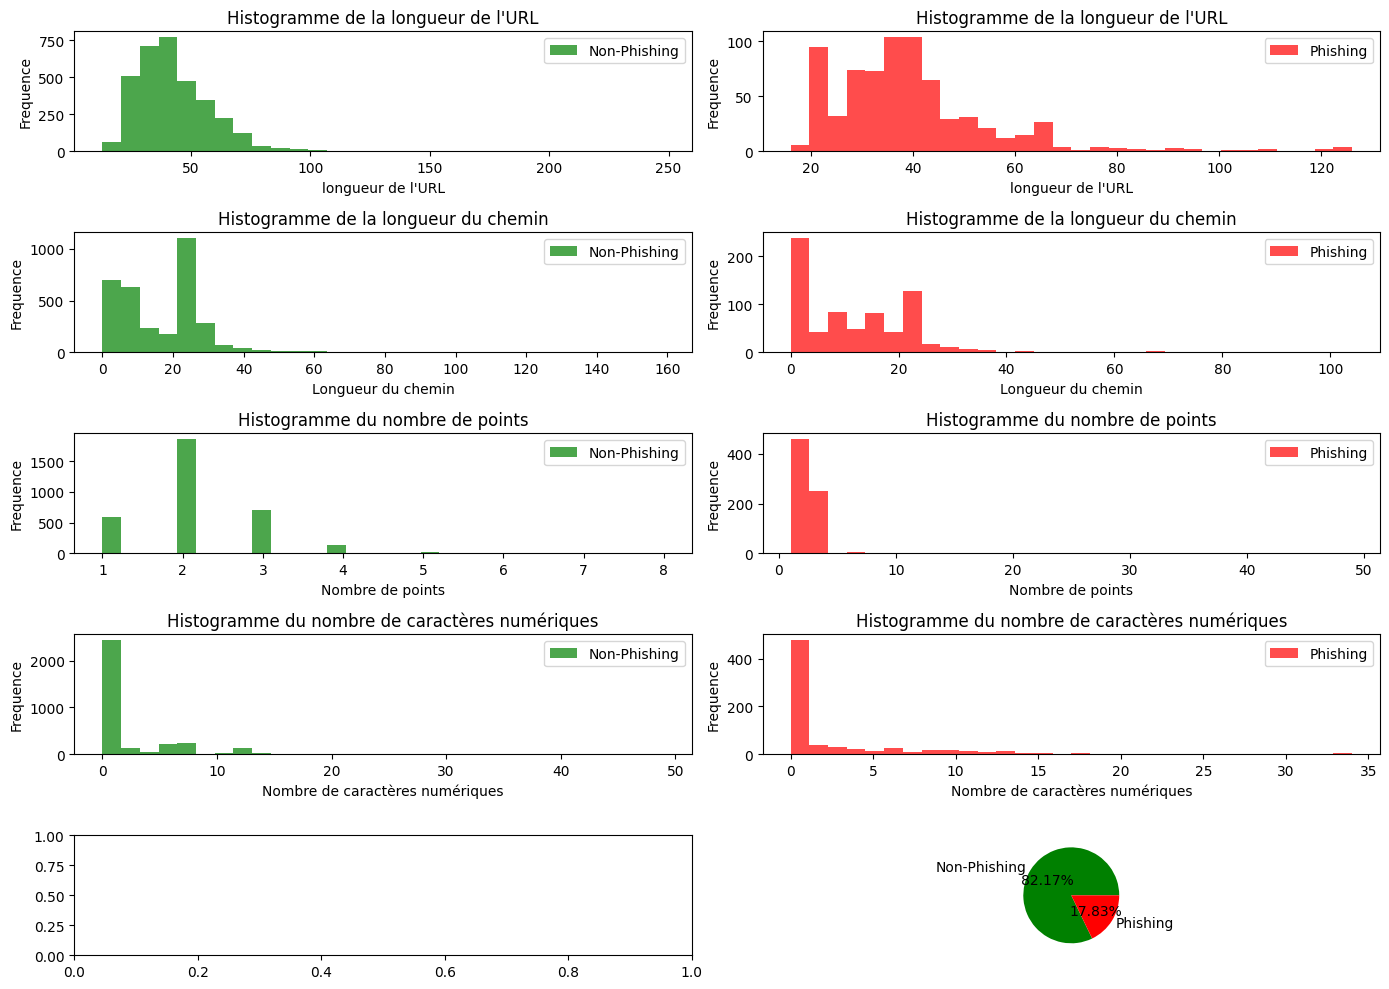

In [226]:
#Présentation des données
phishing_data = df[df['phishing'] == 1.0]
non_phishing_data = df[df['phishing'] < 1]

fig, axs = plt.subplots(5, 2, figsize=(14, 10))

# Histogramme de la longueur de l'URL
axs[0, 0].hist(non_phishing_data['UrlLength'], bins=30, alpha=0.7, label='Non-Phishing', color='green')
axs[0, 0].set_title("Histogramme de la longueur de l'URL")
axs[0, 0].set_xlabel("longueur de l'URL")
axs[0, 0].set_ylabel('Frequence')
axs[0, 0].legend()

axs[0, 1].hist(phishing_data['UrlLength'], bins=30, alpha=0.7, label='Phishing', color='red')
axs[0, 1].set_title("Histogramme de la longueur de l'URL")
axs[0, 1].set_xlabel("longueur de l'URL")
axs[0, 1].set_ylabel('Frequence')
axs[0, 1].legend()

# Histogramme de la longueur du chemin
axs[1, 0].hist(non_phishing_data['PathLength'], bins=30, alpha=0.7, label='Non-Phishing', color='green')
axs[1, 0].set_title('Histogramme de la longueur du chemin')
axs[1, 0].set_xlabel('Longueur du chemin')
axs[1, 0].set_ylabel('Frequence')
axs[1, 0].legend()

axs[1, 1].hist(phishing_data['PathLength'], bins=30, alpha=0.7, label='Phishing', color='red')
axs[1, 1].set_title('Histogramme de la longueur du chemin')
axs[1, 1].set_xlabel('Longueur du chemin')
axs[1, 1].set_ylabel('Frequence')
axs[1, 1].legend()

# Histogramme du nombre de points
axs[2, 0].hist(non_phishing_data['NumDot'], bins=30, alpha=0.7, label='Non-Phishing', color='green')
axs[2, 0].set_title('Histogramme du nombre de points')
axs[2, 0].set_xlabel('Nombre de points')
axs[2, 0].set_ylabel('Frequence')
axs[2, 0].legend()

axs[2, 1].hist(phishing_data['NumDot'], bins=30, alpha=0.7, label='Phishing', color='red')
axs[2, 1].set_title('Histogramme du nombre de points')
axs[2, 1].set_xlabel('Nombre de points')
axs[2, 1].set_ylabel('Frequence')
axs[2, 1].legend()

# Histogramme du nombre de caractères numériques
axs[3, 0].hist(non_phishing_data['NumNumericChars'], bins=30, alpha=0.7, label='Non-Phishing', color='green')
axs[3, 0].set_title('Histogramme du nombre de caractères numériques')
axs[3, 0].set_xlabel('Nombre de caractères numériques')
axs[3, 0].set_ylabel('Frequence')
axs[3, 0].legend()

axs[3, 1].hist(phishing_data['NumNumericChars'], bins=30, alpha=0.7, label='Phishing', color='red')
axs[3, 1].set_title('Histogramme du nombre de caractères numériques')
axs[3, 1].set_xlabel('Nombre de caractères numériques')
axs[3, 1].set_ylabel('Frequence')
axs[3, 1].legend()

# Histogramme HTTPS dans l'url
# labels =  np.arange(0,1)
# axs[4, 0].bar(labels, phishing_data['HttpsInHostname'].count(), align='edge', width=-0.4, color='red')
# axs[4, 0].bar(labels, non_phishing_data['HttpsInHostname'].count(), align='edge', width=0.4, color='green')

df.groupby('phishing').size().plot(kind='pie', autopct='%.2f%%', labels=['Non-Phishing', 'Phishing'], colors=['green', 'red'])

plt.tight_layout()
plt.show()

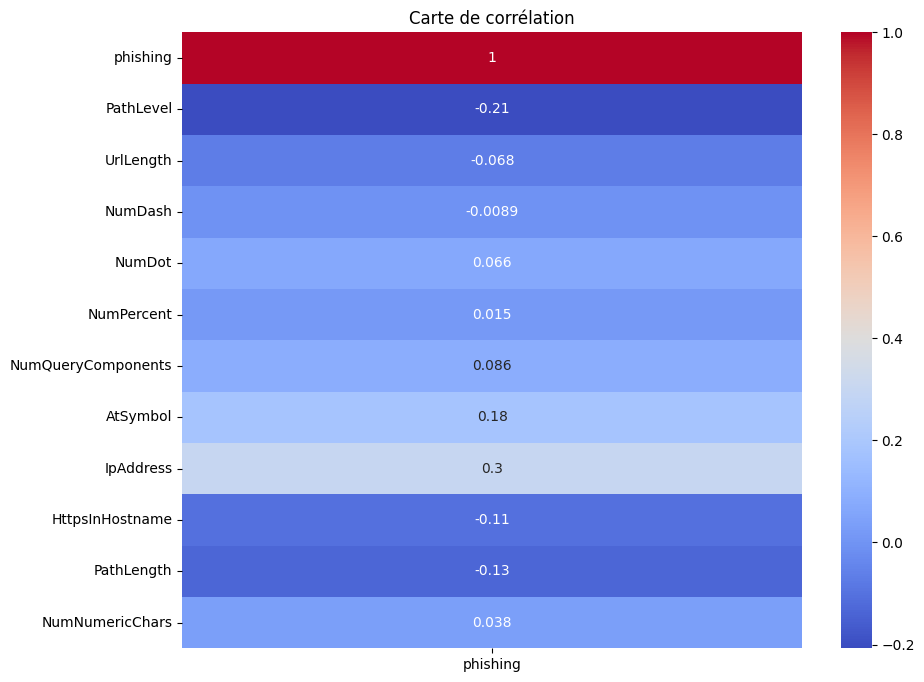

In [227]:
#Analyse corrélation des données
df_corr = df.drop(['email_text','url'], axis=1)
correlation_matrix = df_corr.corr()

x = correlation_matrix[['phishing']]
plt.figure(figsize=(10, 8))
sns.heatmap(x, annot=True, cmap='coolwarm')
plt.title('Carte de corrélation')
plt.show()

In [228]:
#Identification des caractéristiques importantes

#Supposons que toutes les colonnes sauf 'Phising' soient des caractéristiques et 'Phising' la cible
df_sel = df.drop(['email_text','url'], axis=1)
X = df_sel.drop(columns=['phishing'])
y = df_sel['phishing'].dropna()

# #Remplir les valeurs manquantes de y avec une valeur courante (comme la moyenne ou la médiane)
# y = y.fillna(y.median())

#Sélection des caractéristiques les plus importantes
selector = SelectKBest(score_func=chi2, k='all').fit(X, y)
X_transformed = selector.transform(X)
X = X[[val for i,val in enumerate(X.columns) if selector.get_support()[i]]]
print(X)

      PathLevel  UrlLength  NumDash  NumDot  NumPercent  NumQueryComponents  \
0             1         30        0       2           0                   1   
1             3         41        0       2           0                   0   
2             2         34        1       2           0                   0   
3             3        103        0       4           0                   1   
4             6         80        0       7           0                   0   
...         ...        ...      ...     ...         ...                 ...   
4023          2         30        0       2           0                   0   
4024          5         96        0       3           0                   1   
4025          3         52        1       2           0                   0   
4026          4         53        0       2           0                   0   
4027          0         26        2       3           0                   0   

      AtSymbol  IpAddress  HttpsInHostname  PathLen

In [229]:
cvec = CountVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(df['email_text'])
len(cvec.vocabulary_)

cvec_counts = cvec.transform(df['email_text'])
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names_out(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
8066,½ï,6291
8068,½ï ½ï,5143
5826,razor,1445
6733,spam,1057
7,000,1010
2925,file,992
3857,internet,971
4774,money,916
4950,news,870
5834,razor users,869


In [230]:

transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names_out(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
5826,razor,0.018932
6247,rpm list,0.015171
7987,www newsisfree,0.014882
4964,newsisfree com,0.014882
4963,newsisfree,0.014882
1575,com click,0.013763
2741,exmh,0.013235
2024,date 2002,0.012305
5834,razor users,0.012172
6733,spam,0.012099


In [232]:
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english')
tvec_weights = tvec.fit_transform(df['email_text'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names_out(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
4089,razor,0.023044
3421,newsisfree,0.019760
1921,exmh,0.015297
5568,yahoo,0.014408
4997,talk,0.014393
4728,spam,0.013895
3702,perl,0.013371
5079,thinkgeek,0.012880
2203,freshrpms,0.012238
4150,redhat,0.010368


In [ ]:
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit import BasicAer